# Import required packages

In [12]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import os
import scipy.io.wavfile
import numpy as np
import sys
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, AveragePooling1D, BatchNormalization, Input, Flatten, Dropout, Activation
import live_plot
import fetch_label

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Reading audio data

In [26]:
import os
train_data_path='data/'
mylist = []
for path, subdirs, files in os.walk(train_data_path):
    for name in files:
        mylist.append(os.path.join(path, name))

## Plotting audio file

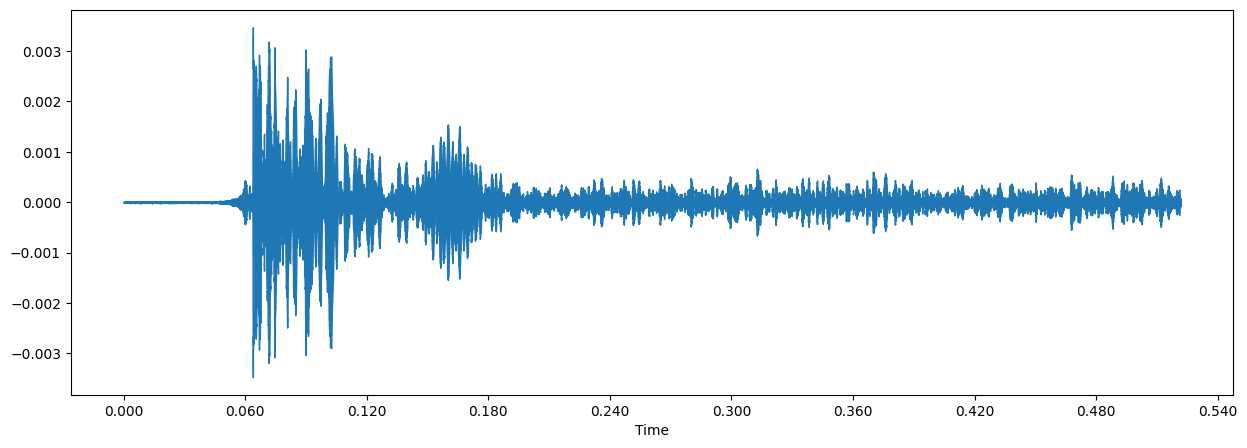

In [27]:
data_path='C:/Users/joseg/OneDrive/Documentos/todo/klover/emotion-recognition/emotion_recognizer_webapp/Grabación.wav'
data, sampling_rate = librosa.load(data_path)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

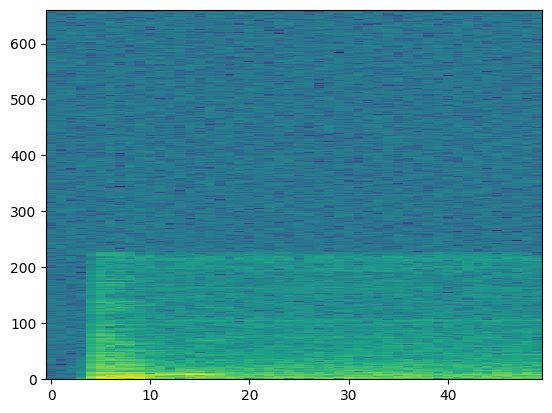

In [30]:
sr,x = scipy.io.wavfile.read(data_path)
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin
window = np.hamming(nwin)
nn = range(nwin, len(x), nstep)
X = np.zeros( (len(nn), nfft//2) )

x = np.mean(x, axis=1)
for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')
plt.show()

## Extract features from audio using librosa

In [32]:

label = fetch_label.FetchLabel()
df = pd.DataFrame(columns=['feature','emotion'])
bookmark=0
for index,y in enumerate(mylist):
    X, sample_rate = librosa.load(y, res_type='kaiser_fast',duration=3,sr=22050*2,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    emotion = label.get_emotion(y)
    df.loc[bookmark] = [feature, emotion]
    bookmark=bookmark+1        

ModuleNotFoundError: No module named 'resampy'

This error is lazily reported, having originally occured in
  File c:\Users\joseg\OneDrive\Documentos\todo\klover\emotion-recognition\env\lib\site-packages\librosa\core\audio.py, line 32, in <module>

----> resampy = lazy.load("resampy")

## Data Preprocessing

In [5]:
feature_df = pd.DataFrame(df['feature'].values.tolist())
labelled_df = pd.concat([feature_df,df['emotion']], axis=1)
df_cleaned = labelled_df.dropna(0)
shuffled_df = df_cleaned.sample(frac=1).reset_index(drop=True)
shuffled_df = shuffled_df.loc[~shuffled_df['emotion'].isin(['male_neutral', 'male_disgusted', 'male_surprised', 'female_neutral', 'female_disgusted', 'female_surprised'])]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(shuffled_df.drop('emotion', axis =1), shuffled_df['emotion'], test_size=0.2, random_state=0, shuffle = True)

## Encoding Lables and saving locally

In [7]:
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
np.save('label_classes.npy', lb.classes_)

## Dimension Expansion for modelling

In [8]:
x_train_exp = np.expand_dims(X_train, axis=2)
x_test_exp = np.expand_dims(X_test, axis=2)

## Model Architecture and Training

In [ ]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(x_train_exp.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(initial_learning_rate=0.0001, decay=1e-6)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

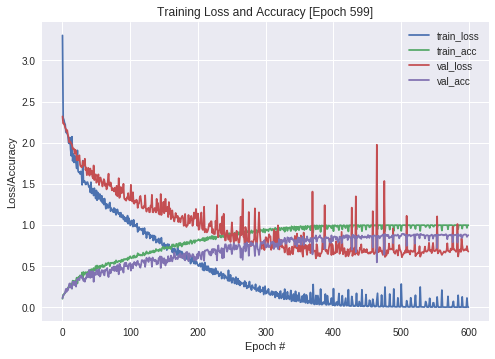

In [49]:
history = model.fit(x_train_exp, y_train, batch_size=512, epochs=600, validation_data = [x_test_exp, y_test], callbacks = [plot_losses])

In [50]:
train_result = model.evaluate(x_train_exp, y_train, verbose=0)
test_result = model.evaluate(x_test_exp, y_test, verbose=0)

print("train acc","%s: %.2f%%" % (model.metrics_names[1], train_result[1]*100))
print("train acc","%s: %.2f%%" % (model.metrics_names[1], test_result[1]*100))

('train acc', 'acc: 99.51%')
('train acc', 'acc: 87.79%')


In [52]:
preds = model.predict(x_test_exp, batch_size=512, verbose=1)
preds_mod = preds.argmax(axis=1)
preds_flat = preds_mod.astype(int).flatten()
preds_transformed = (lb.inverse_transform((preds_flat)))
pred_df = pd.DataFrame({'predictedvalues': preds_transformed})
actual_values = y_test.argmax(axis=1)
actual_values_mod = actual_values.astype(int).flatten()
actual_values_mod_transformed = (lb.inverse_transform((actual_values_mod)))
actual_df = pd.DataFrame({'actualvalues': actual_values_mod_transformed})
final_df = actual_df.join(pred_df)
final_df.head(10)

,actualvalues,predictedvalues
0,female_sad,female_sad
1,male_happy,male_fearful
2,female_calm,female_calm
3,male_calm,male_sad
4,female_sad,female_sad
5,female_angry,female_angry
6,male_happy,male_happy
7,female_fearful,female_fearful
8,male_sad,male_sad
9,male_fearful,male_fearful


In [53]:
final_df.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,76
female_calm,78
female_fearful,54
female_happy,64
female_sad,70
male_angry,81
male_calm,70
male_fearful,62
male_happy,81


In [54]:
final_df.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,84
female_calm,68
female_fearful,50
female_happy,63
female_sad,65
male_angry,80
male_calm,62
male_fearful,69
male_happy,87


In [ ]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)